## Import libraries

In [33]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import networkx as nx
import math
from empiricaldist import Pmf
import random
from collections import deque
from matplotlib.animation import FuncAnimation, PillowWriter
import pandas as pd
import os

if not os.path.exists(os.getcwd()+ '\\output'):
    os.makedirs(os.getcwd()+'\\output')

## Util Functions

In [34]:
def degrees(G):
    """Trả về danh sách bậc (số cạnh) của từng đỉnh trong đồ thị G.

    G: Đối tượng đồ thị

    Kết quả: Danh sách các số nguyên tương ứng với bậc của các đỉnh.
    """
    return [G.degree(u) for u in G]

def all_pairs(nodes):
    """Tạo tất cả cặp đỉnh từ danh sách các đỉnh.

    nodes: Danh sách các đỉnh trong đồ thị.
    
    Kết quả: Từng cặp đỉnh (u, v) với điều kiện u < v (không lặp lại và không đối xứng).
    """
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

def node_clustering(G, u):
    """Tính hệ số cụm (clustering coefficient) của một đỉnh u trong đồ thị G.

    G: Đồ thị
    u: Đỉnh cần tính hệ số cụm
    
    Kết quả: Hệ số cụm của đỉnh u.
    """
    neighbors = G[u]  # Lấy các đỉnh láng giềng của u
    k = len(neighbors)  # Đếm số đỉnh láng giềng
    if k < 2:  # Nếu có ít hơn 2 đỉnh láng giềng, không thể tạo tam giác
        return np.nan

    # Kiểm tra xem các đỉnh láng giềng có liên kết với nhau không (cặp đôi)
    edges = [G.has_edge(v, w) for v, w in all_pairs(neighbors)]
    return np.mean(edges)  # Tính trung bình các cạnh giữa láng giềng

def clustering_coefficient(G):
    """Tính hệ số cụm trung bình của tất cả các đỉnh trong đồ thị G.

    G: Đồ thị
    
    Kết quả: Hệ số cụm trung bình (loại bỏ giá trị NaN).
    """
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

def path_lengths(G):
    """Tạo tất cả khoảng cách ngắn nhất giữa các cặp đỉnh trong đồ thị G.

    G: Đồ thị
    
    Kết quả: Khoảng cách ngắn nhất giữa từng cặp đỉnh.
    """
    length_iter = nx.shortest_path_length(G)  # Tính khoảng cách ngắn nhất
    for source, dist_map in length_iter:
        for dest, dist in dist_map.items():
            if source != dest:  # Loại bỏ khoảng cách từ đỉnh đến chính nó
                yield dist

def characteristic_path_length(G):
    """Tính độ dài đường đi đặc trưng (độ dài trung bình của tất cả đường đi ngắn nhất).

    G: Đồ thị
    
    Kết quả: Độ dài đường đi đặc trưng (số thực).
    """
    return np.mean(list(path_lengths(G)))

def savefig(filename, **options):
    """Lưu hình vẽ hiện tại vào file.

    filename: Tên file (chuỗi ký tự)
    options: Tham số tùy chọn cho hàm plt.savefig
    """
    print("Lưu hình vào file", filename)
    plt.savefig(filename, **options)

def underride(d, **options):
    """Thêm các cặp key-value vào từ điển `d` nếu key chưa tồn tại.

    d: Từ điển
    options: Các tham số key-value cần thêm
    
    Kết quả: Từ điển đã cập nhật.
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d

def legend(**options):
    """Vẽ chú thích (legend) nếu có ít nhất một mục có nhãn.

    options: Tham số tùy chọn cho hàm plt.legend.
    """
    underride(options, loc="best", frameon=False)

    ax = plt.gca()  # Lấy trục hiện tại
    handles, labels = ax.get_legend_handles_labels()
    if handles:  # Chỉ vẽ legend nếu có mục nhãn
        ax.legend(handles, labels, **options)

def decorate(**options):
    """Trang trí biểu đồ hiện tại với các thông số như tiêu đề, nhãn trục và chú thích.

    Tham số:
    - title: Tiêu đề của biểu đồ
    - xlabel, ylabel: Nhãn của trục x và y
    - legend: Hiển thị chú thích (mặc định True)
    - loc: Vị trí của chú thích (mặc định 'best')
    """
    loc = options.pop("loc", "best")
    if options.pop("legend", True):
        legend(loc=loc)  # Gọi hàm legend

    plt.gca().set(**options)  # Cập nhật trục hiện tại với các thông số
    plt.tight_layout()  # Sắp xếp lại bố cục để tránh trùng lặp


## Load and preprocess the dataset 

In [35]:
stations = gpd.read_file('hanoi_nodes.geojson')
routes = gpd.read_file('hanoi_edges.geojson')
stations

,name,name,geometry
0,Yên Viên,None,POINT (105.91553 21.08581)
1,Yên Nghĩa,None,POINT (105.74812 20.9497)
2,Hà Nội,None,POINT (105.84107 21.02521)
3,Văn Quán,None,POINT (105.7848 20.9779)
4,Văn Khê,None,POINT (105.75613 20.95591)
5,Văn Điển,None,POINT (105.84423 20.9444)
6,Thái Hà,None,POINT (105.81951 21.01476)
7,Phùng Khoang,None,POINT (105.79312 20.98448)
8,Phú Diễn(1),None,POINT (105.76491 21.0517)
9,Minh Khai,None,POINT (105.74486 21.04816)


### Preprocess nodes

In [36]:
# Trích xuất tọa độ kinh độ (longitude) và vĩ độ (latitude) từ cột 'geometry'
stations['lon'], stations['lat'] = stations.geometry.x, stations.geometry.y

# Thêm một cột giá trị mặc định là 4 (giả sử đây là giá trị cho các trạm)
stations['value'] = 4

# Xác định kinh độ và vĩ độ nhỏ nhất từ dữ liệu
min_lon = min(stations['lon'])  # Kinh độ nhỏ nhất
min_lat = min(stations['lat'])  # Vĩ độ nhỏ nhất

# Chuẩn hóa và chuyển đổi giá trị kinh độ sang tọa độ x (scaling lon -> x)
stations['x'] = stations.lon.apply(lambda x: int((x - min_lon) * (10**3)))

# Chuẩn hóa và chuyển đổi giá trị vĩ độ sang tọa độ y (scaling lat -> y)
stations['y'] = stations.lat.apply(lambda y: int((y - min_lat) * (10**3)))

# **Bước lọc dữ liệu nếu cần (đã comment sẵn):**
# Chỉ giữ lại các trạm nằm trong khoảng giá trị tọa độ x và y cụ thể
# stations = stations[((stations['x']>150) & (stations['x']<500)) & ((stations['y']>530) & (stations['y']<800))]

# Tìm giá trị x và y nhỏ nhất sau khi chuẩn hóa
min_x = min(stations['x'])  # Giá trị x nhỏ nhất
min_y = min(stations['y'])  # Giá trị y nhỏ nhất

# Dịch chuyển tọa độ x để bắt đầu từ 10 (đảm bảo giá trị x không bị âm)
stations['x'] = stations.x.apply(lambda x: int(x - min_x) + 10)

# Dịch chuyển tọa độ y để bắt đầu từ 10 (đảm bảo giá trị y không bị âm)
stations['y'] = stations.y.apply(lambda y: int(y - min_y) + 10)

# Kết hợp tọa độ x và y thành tuple (điểm dạng (x, y)) và lưu vào cột 'nodes'
stations['nodes'] = stations[['x', 'y']].apply(tuple, axis=1)

# Loại bỏ các trạm trùng nhau dựa trên cột 'nodes'
stations = stations.drop_duplicates(subset=['nodes'])

# Hiển thị 5 dòng đầu tiên của bảng dữ liệu
stations.head()


,name,name,geometry,lon,lat,value,x,y,nodes
0,Yên Viên,None,POINT (105.91553 21.08581),105.915532,21.085809,4,190,151,"(190, 151)"
1,Yên Nghĩa,None,POINT (105.74812 20.9497),105.748116,20.949705,4,22,15,"(22, 15)"
2,Hà Nội,None,POINT (105.84107 21.02521),105.841074,21.025205,4,115,90,"(115, 90)"
3,Văn Quán,None,POINT (105.7848 20.9779),105.784805,20.977901,4,59,43,"(59, 43)"
4,Văn Khê,None,POINT (105.75613 20.95591),105.756127,20.955915,4,30,21,"(30, 21)"



### Preprocess edges

In [37]:
# Thêm một cột 'nodes' với giá trị mặc định là "None" cho các tuyến đường
routes['nodes'] = "None"

# Tạo một tập hợp để lưu trữ các trạm đã chọn
selected_stations = set()

# Lặp qua từng dòng trong DataFrame 'routes' để xử lý từng tuyến đường
for i, route in routes.iterrows():
    # Tạo một danh sách nodes (các điểm kết nối) có độ dài bằng số tọa độ của đường đi
    nodes = [None] * len(route['geometry'].coords)

    # Lặp qua từng trạm trong DataFrame 'stations'
    for k, station in stations.iterrows():
        # Lấy tọa độ hình học của trạm hiện tại
        point = station['geometry']

        # Kiểm tra khoảng cách giữa trạm và tuyến đường
        if route['geometry'].distance(point) < 1e-3:  # Điều kiện khoảng cách rất nhỏ (1e-3)
            min_dist = -1  # Khởi tạo khoảng cách nhỏ nhất là -1
            min_j = 0      # Chỉ số của tọa độ gần nhất trên tuyến đường

            # Lặp qua các điểm tọa độ trong tuyến đường
            for j, node in enumerate(route['geometry'].coords):
                idx = (point.x, point.y)  # Tạo tọa độ của trạm
                dist = math.dist(node, idx)  # Tính khoảng cách Euclidean

                # Cập nhật khoảng cách nhỏ nhất và vị trí gần nhất trên tuyến đường
                if dist < min_dist or min_dist == -1:
                    min_dist = dist
                    min_j = j

            # Kiểm tra xem vị trí gần nhất đã được gán hay chưa
            if nodes[min_j] is not None:
                min_j += 1  # Di chuyển sang chỉ số tiếp theo nếu vị trí đã được gán

            # Gán node của trạm hiện tại vào danh sách nodes
            nodes[min_j] = station['nodes']

    # Loại bỏ các giá trị None trong danh sách nodes
    nodes = [x for x in nodes if x]

    # Gán danh sách nodes vào cột 'nodes' của tuyến đường hiện tại
    routes.at[i, 'nodes'] = nodes

# Lọc các tuyến đường có danh sách nodes không rỗng
routes = routes[routes['nodes'].map(lambda d: len(d)) > 0]

# Hiển thị 5 dòng đầu tiên của DataFrame 'routes'
routes.head()


,geometry,nodes
0,"LINESTRING (105.87878 21.05161, 105.87518 21.0...","[(153, 117), (124, 105)]"
1,"LINESTRING (105.85003 21.03984, 105.84718 21.0...","[(124, 105), (115, 90)]"
2,"LINESTRING (105.84105 21.0252, 105.84084 21.01...","[(115, 90), (115, 44)]"
3,"LINESTRING (105.84042 20.97908, 105.84067 20.9...","[(115, 44), (118, 10)]"
4,"LINESTRING (105.91832 21.02843, 105.91334 21.0...","[(193, 94), (153, 117)]"


## Visualise the data in NetworkX

Saving figure to file output/original_graph.png


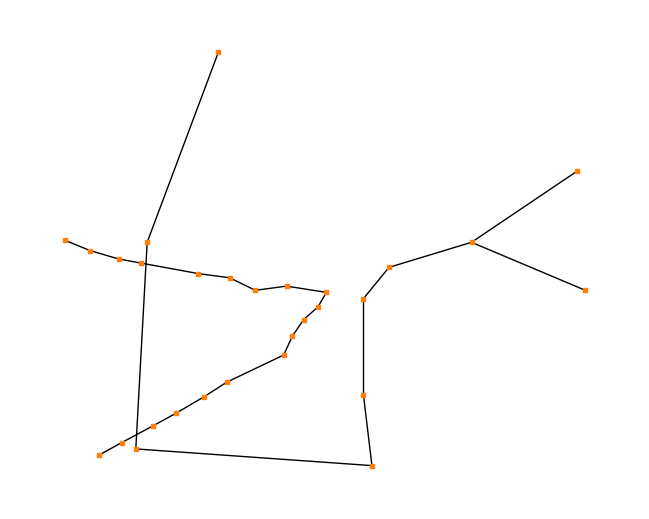

In [38]:
# Tạo một đồ thị vô hướng (Graph) bằng NetworkX
G = nx.Graph()

# Duyệt qua danh sách nodes (các điểm nối) của từng tuyến đường
for nodes in routes['nodes']:
    # Kết nối các điểm liền kề trong danh sách nodes để tạo các cạnh (edges)
    for seg_start, seg_end in zip(nodes, nodes[1:]):
        G.add_edge(seg_start, seg_end)

# Tạo vị trí của các nodes dưới dạng dictionary {node: [x, y]}
positions = {n: [n[0], n[1]] for n in list(G.nodes)}

# Tạo một biểu đồ với kích thước (6.3, 5) inch
fig = plt.figure(figsize=(6.3, 5))

# Vẽ đồ thị G với các tùy chỉnh sau:
# - positions: vị trí các nodes (tọa độ x và y)
# - node_color='C1': màu sắc của các nút
# - node_shape='s': hình dạng các nút (hình vuông)
# - node_size=12: kích thước các nút
# - with_labels=False: không hiển thị nhãn cho các nút
nx.draw(G, positions,
        node_color='C1',
        node_shape='s',
        node_size=12,
        with_labels=False)

# Lưu biểu đồ vào file 'output/original_graph.png'
savefig('output/original_graph.png')


## Slime Mould

### Cell

In [39]:
class Cell:
    def __init__(self, pheromone=0., cell_type=0):
        """
        Phương thức khởi tạo của lớp Cell.
        
        Args:
            pheromone (float): Lượng pheromone trong ô, mặc định là 0.0.
            cell_type (int): Loại của ô, mặc định là 0.
        """
        self.pheromone = pheromone  # Lượng pheromone hiện tại của ô
        self.cell_type = cell_type  # Loại của ô (ví dụ: 0 = ô trống, 1 = chướng ngại vật, v.v.)

    def get_cell_type(self):
        """
        Phương thức trả về loại của ô (cell_type).

        Returns:
            int: Giá trị của thuộc tính cell_type.
        """
        return self.cell_type


### Food

In [40]:
class FoodCell(Cell):
    def __init__(self, food_id: int, food_idx: tuple):
        """
        Phương thức khởi tạo của lớp FoodCell, kế thừa từ lớp Cell.

        Args:
            food_id (int): ID của thức ăn.
            food_idx (tuple): Tọa độ của thức ăn trong lưới (ví dụ: (x, y)).
        """
        super().__init__(pheromone=10., cell_type=2)  # Gọi hàm khởi tạo lớp cha với pheromone = 10 và cell_type = 2.
        self.food_id = food_id      # ID của thức ăn.
        self.food_idx = food_idx    # Tọa độ của thức ăn.
        self.pheromone = 10.        # Thiết lập lại pheromone của ô chứa thức ăn.

    def get_food_idx(self):
        """
        Phương thức trả về tọa độ của thức ăn.

        Returns:
            tuple: Tọa độ (x, y) của thức ăn.
        """
        return self.food_idx

    def get_food_id(self):
        """
        Phương thức trả về ID của thức ăn.

        Returns:
            int: ID của thức ăn.
        """
        return self.food_id


### Slime

In [41]:
DIFFUSION_THRESHOLD = 3.5
DIFFUSION_DECAY_RATE = 1.26
DISTANCE_FOR_DIFFUSION_THRESHOLD = 55
MOVING_THRESHOLD = 1
MAX_PH = 5.5
MAX_PH_INCREASE_STEP = 0.2


def get_neighbours(idx):
    """
    Lấy chỉ mục của các ô lân cận của ô slime đầu vào
    :param idx: chỉ mục của ô slime
    :return: danh sách chỉ mục của các ô lân cận
    """
    return [
        (idx[0] - 1, idx[1] - 1),  # lên 1, trái 1
        (idx[0] - 1, idx[1]),  # lên 1,
        (idx[0] - 1, idx[1] + 1),  # lên 1, phải 1
        (idx[0], idx[1] - 1),  # trái 1
        (idx[0], idx[1] + 1),  # phải 1
        (idx[0] + 1, idx[1] - 1),  # xuống 1, trái 1
        (idx[0] + 1, idx[1]),  # xuống 1,
        (idx[0] + 1, idx[1] + 1),  # xuống 1, phải 1
    ]


def step_direction(index: int, idx: tuple):
    """
    Lấy bước di chuyển tiếp theo của ô slime
    :param index: chỉ mục hướng đi
    :param idx: chỉ mục của ô slime
    :return: chỉ mục của bước di chuyển tiếp theo
    """
    next_step = {
        0: (0, 0),
        1: (-1, -1),
        2: (1, -1),
        3: (-1, 1),
        4: (1, 1),
        5: (-1, 0),
        6: (1, 0),
        7: (0, -1),
        8: (0, 1)
    }
    return next_step[index][0] + idx[0], next_step[index][1] + idx[1]


class SlimeCell(Cell):

    def __init__(self, idx: tuple, pheromone: float, mould, dish, is_capital):
        super().__init__(pheromone=pheromone, cell_type=1)

        self.idx = idx  # Chỉ mục của ô slime
        self.pheromone = pheromone  # Nồng độ pheromone của ô slime
        self.max_ph = 4  # Giá trị pheromone tối đa mà ô slime có thể đạt được
        self.direction = None  # Hướng di chuyển
        self.is_capital = is_capital  # Kiểm tra xem ô slime có phải là ô đầu tiên không
        self.reached_food_id = None  # ID của thức ăn mà ô slime đã đạt được
        self.mould = mould  # Đối tượng mô hình
        self.dish = dish  # Đối tượng đĩa
        self.food_path = []  # Đường đi của thức ăn mà ô slime sẽ di chuyển

        # (food_id, food_idx)
        self.step_food = None  # Thức ăn sẽ được ô slime tiếp cận tiếp theo
        self.curr_target = None  # Mục tiêu hiện tại của ô slime

    def find_nearest_food(self, food_ids):
        """
        Tìm thức ăn gần nhất đối với ô slime
        :param food_ids: danh sách ID thức ăn
        :return: min_i: ID thức ăn gần nhất, min_dist: khoảng cách đến thức ăn gần nhất
        """
        min_dist = -1
        min_i = 0
        # Tìm thức ăn gần nhất
        for i in food_ids:
            food_idx = self.dish.get_food_position(i)
            dist = math.dist(self.idx, food_idx)
            if min_dist > dist or min_dist < 0:
                min_dist = dist
                min_i = i
        return min_i, min_dist

    def set_reached_food_path(self):
        """
        Thiết lập đường đi của thức ăn mà ô slime sẽ đi qua
        """
        # Mục tiêu thức ăn (food_id, food_idx)
        target_food_id = self.mould.get_current_target()[0]
        self.curr_target = target_food_id

        mould_reached_food_ids = self.mould.get_reached_food_ids()

        if len(mould_reached_food_ids) == 0:
            self.food_path.append(self.mould.get_current_target()[0])

        else:
            # Tìm thức ăn gần nhất
            min_i = self.find_nearest_food(food_ids=self.mould.get_reached_food_ids())[0]

            nearest_target = self.mould.get_nearest_connected_target()
            if nearest_target != -1:
                # Tìm đường đi ngắn nhất từ thức ăn gần nhất đến thức ăn mục tiêu
                self.food_path = nx.shortest_path(G=self.dish.get_food_graph(), source=min_i,
                                                  target=nearest_target)
            else:
                self.food_path.append(min_i)
            self.food_path.append(target_food_id)
        step_food_id = self.food_path.pop(0)
        self.step_food = (step_food_id, self.dish.get_food_position(step_food_id))

    def reset_step_food(self):
        """
        Cập nhật thức ăn bước tiếp theo mà ô slime sẽ đi đến
        """
        # Nếu đã đạt được mục tiêu thức ăn
        if self.reached_food_id == self.curr_target and self.curr_target == self.mould.get_current_target()[0]:
            return

        if self.step_food is None or len(self.food_path) == 0:
            self.set_reached_food_path()
        else:
            # Nếu đã đạt đến thức ăn tiếp theo
            step_food_idx = self.dish.get_food_position(self.step_food[0])
            if math.dist(step_food_idx, self.idx) < 3:
                step_food_id = self.food_path.pop(0)
                self.step_food = (step_food_id, self.dish.get_food_position(step_food_id))

    def sensory(self):
        """
        Thiết lập hướng di chuyển tiếp theo dựa trên vị trí của thức ăn
        """
        if self.reached_food_id == self.step_food:
            self.reset_step_food()
        food_idx = self.step_food[1]

        # (-1, -1)
        if food_idx[0] < self.idx[0] and food_idx[1] < self.idx[1]:
            self.direction = 1
        # (1, -1)
        elif food_idx[0] > self.idx[0] and food_idx[1] < self.idx[1]:
            self.direction = 2
        # (-1, 1)
        elif food_idx[0] < self.idx[0] and food_idx[1] > self.idx[1]:
            self.direction = 3
        # (1, 1)
        elif food_idx[0] > self.idx[0] and food_idx[1] > self.idx[1]:
            self.direction = 4
        # (-1, 0)
        elif food_idx[0] < self.idx[0]:
            self.direction = 5
        # (1, 0)
        elif food_idx[0] > self.idx[0]:
            self.direction = 6
        # (0, -1)
        elif food_idx[1] < self.idx[1]:
            self.direction = 7
        # (0, 1)
        elif food_idx[1] > self.idx[1]:
            self.direction = 8

    @staticmethod
    def check_boundary(idx, lattice_shape):
        """
        Kiểm tra xem ô lân cận có vượt qua biên của lưới hay không
        :param idx: vị trí của ô lân cận
        :param lattice_shape: kích thước của lưới
        :return: trả về False nếu vượt biên, ngược lại trả về True
        """
        if idx[0] >= lattice_shape[0] or idx[0] <= 0 or idx[1] >= lattice_shape[1] or idx[1] <= 0:
            return False
        return True

    # hàm khuếch tán pheromone của tế bào slime
def diffusion(self, lattice, decay):
    """
    Tế bào slime kiểm tra tất cả 8 tế bào lân cận và thực hiện khuếch tán pheromone dựa trên các điều kiện.
    1. Thực hiện khuếch tán trên hướng di chuyển chính đầu tiên.
    2. Tiến hành khuếch tán các tế bào còn lại nếu chưa đạt ngưỡng DIFFUSION THRESHOLD.
    3. Có các chiến lược khuếch tán khác nhau cho từng loại tế bào lân cận (tế bào trống, slime, thức ăn, ranh giới).
    4. Pheromone của tế bào slime sẽ giảm sau mỗi lần khuếch tán.
    :param lattice: Lưới chứa các tế bào
    :param decay: Tỷ lệ giảm pheromone của tế bào slime
    """
    # Tính toán bước di chuyển tiếp theo
    new_idx = step_direction(self.direction, self.idx)
    neighbours = get_neighbours(self.idx)

    # Đảm bảo rằng bước di chuyển chính là bước đầu tiên trong danh sách lân cận
    neighbours.remove(new_idx)
    neighbours = deque(neighbours)
    neighbours.appendleft(new_idx)

    # Duyệt qua các lân cận và thực hiện khuếch tán pheromone
    while neighbours:
        neigh = neighbours.popleft()

        # Bỏ qua nếu tế bào lân cận nằm ngoài ranh giới
        if not self.check_boundary(neigh, lattice.shape):
            continue

        neigh_cell = lattice[neigh]

        # Nếu tế bào lân cận là một tế bào trống
        if neigh_cell.get_cell_type() == 0:
            # Nếu tế bào trống là tế bào di chuyển chính và pheromone đủ lớn
            if neigh == new_idx and self.pheromone > MOVING_THRESHOLD:
                self.mould.slime_cell_generator(idx=neigh, pheromone=self.pheromone, decay=decay,
                                                is_capital=self.is_capital)
                self.pheromone *= (1 - DIFFUSION_DECAY_RATE * decay)
                self.is_capital = False
                continue

            # Nếu pheromone đủ lớn và có thức ăn gần đó, tạo tế bào slime mới tại vị trí này
            if self.pheromone > DIFFUSION_THRESHOLD and \
                    self.find_nearest_food(self.mould.get_reached_food_ids())[1] < DISTANCE_FOR_DIFFUSION_THRESHOLD:
                self.mould.slime_cell_generator(idx=neigh, pheromone=self.pheromone/DIFFUSION_DECAY_RATE, decay=decay)
                self.pheromone *= (1 - (2 * DIFFUSION_DECAY_RATE * decay))

        # Nếu tế bào lân cận là một tế bào slime
        elif neigh_cell.get_cell_type() == 1:
            # Nếu tế bào slime lân cận là tế bào di chuyển chính
            if neigh == new_idx and self.pheromone > MOVING_THRESHOLD:
                neigh_increase_ph = neigh_cell.pheromone + self.pheromone / DIFFUSION_DECAY_RATE
                if neigh_increase_ph > neigh_cell.max_ph:
                    neigh_cell.pheromone = neigh_cell.max_ph
                else:
                    neigh_cell.pheromone = neigh_increase_ph
                self.pheromone /= DIFFUSION_DECAY_RATE

                # Cập nhật thông tin tế bào slime
                self.mould.update_slime_cell(new_idx, neigh_cell)

            # Nếu tế bào slime lân cận có pheromone lớn hơn, tăng pheromone của bản thân
            if neigh_cell.pheromone > self.pheromone and self.max_ph < MAX_PH:
                self.max_ph += MAX_PH_INCREASE_STEP
                self.pheromone += (neigh_cell.pheromone / 10)

        # Nếu tế bào lân cận chứa thức ăn
        elif neigh_cell.get_cell_type() == 2:
            # Tế bào slime "ăn" thức ăn và pheromone sẽ được đặt lại
            self.pheromone = 7
            self.max_ph = 7
            self.reached_food_id = neigh_cell.get_food_id()
            new_food_id = neigh_cell.get_food_id()
            if new_food_id not in self.mould.get_reached_food_ids():
                self.mould.update_food_connection(new_food_id)
                self.mould.get_reached_food_ids().add(new_food_id)

    # Cập nhật tế bào slime sau khi khuếch tán
    self.mould.update_slime_cell(self.idx, self)

# Hàm thực hiện một bước của tế bào slime, bao gồm cả cảm nhận và khuếch tán
def step(self, lattice, decay):
    """
    Giai đoạn cảm nhận: tất cả tế bào slime điều chỉnh hướng di chuyển dựa trên thức ăn.
    Giai đoạn khuếch tán: tất cả pheromone được khuếch tán trong không gian lưới.
    """
    self.sensory()  # Cảm nhận môi trường xung quanh
    self.diffusion(lattice, decay)  # Khuếch tán pheromone

# Trả về chỉ số của tế bào slime
def get_idx(self):
    return self.idx

# Trả về lượng pheromone hiện tại của tế bào slime
def get_pheromone(self):
    return self.pheromone

# Đặt giá trị pheromone cho tế bào slime
def set_pheromone(self, ph):
    self.pheromone = ph

# Trả về ID của thức ăn mà tế bào slime đã tìm thấy
def get_reached_food_id(self):
    return self.reached_food_id

# Đặt trạng thái tế bào slime là không phải tế bào chính
def remove_capital(self):
    self.is_capital = False

### Mould

In [42]:
TARGET_SWITCH_THRESHOLD = 5  # Đặt ngưỡng chuyển đổi mục tiêu sau một số bước nhất định

def get_corner_slime_cells(slime_cells, current_direction, direction_list=None):
    """
    Lấy tế bào slime ở góc của môi trường mốc để quyết định mục tiêu thức ăn tiếp theo.
    :return: tế bào slime ở góc đã chọn.
    """
    slime_idx = slime_cells.keys()  # Lấy các chỉ số của các tế bào slime
    curr_capital_slime = None  # Khởi tạo tế bào slime chính (capital slime)

    # Tùy vào hướng hiện tại để chọn tế bào slime ở góc phù hợp
    if current_direction == 0:
        curr_capital_slime = slime_cells[min(slime_idx)]
    elif current_direction == 1:
        max_x = max([x for x, y in slime_idx])
        for x, y in slime_idx:
            if x == max_x:
                curr_capital_slime = slime_cells[(x, y)]
                break
    elif current_direction == 2:
        min_y = min([y for x, y in slime_idx])
        for x, y in slime_idx:
            if y == min_y:
                curr_capital_slime = slime_cells[(x, y)]
                break
    elif current_direction == 3:
        curr_capital_slime = slime_cells[max(slime_idx)]

    # Nếu tế bào slime đã tìm thấy thức ăn, kiểm tra lại hướng nếu cần thiết
    if curr_capital_slime.get_reached_food_id() is not None:
        if direction_list is not None:
            direction_list.remove(current_direction)
        else:
            direction_list = [0, 1, 2, 3]
        get_corner_slime_cells(slime_cells, random.choice(direction_list))
    return curr_capital_slime


class Mould:
    def __init__(self, dish, start_loc: tuple, mould_shape: tuple, init_mould_coverage: float, decay: float):
        """
        Khởi tạo môi trường mốc (Mould) với các thông số ban đầu.
        :param dish: Món ăn (đĩa thức ăn).
        :param start_loc: Vị trí bắt đầu của môi trường mốc.
        :param mould_shape: Hình dạng của môi trường mốc.
        :param init_mould_coverage: Tỷ lệ bao phủ ban đầu của môi trường mốc.
        :param decay: Tốc độ phân hủy của các tế bào slime.
        """
        self.dish = dish
        self.decay = decay
        self.slime_cells = {}  # Lưu trữ các tế bào slime
        self.mould_shape = mould_shape
        self.reached_food_ids = set()  # Thực phẩm đã được tìm thấy
        self.current_target = 0  # Mục tiêu thức ăn hiện tại
        self.nearest_connected_target = -1  # Mục tiêu kết nối gần nhất
        self.capital_slime = None  # Tế bào slime chính
        self.initialise(start_loc, mould_shape, init_mould_coverage)

        # Các thống kê sau mỗi bước tiến hóa
        self.avg_ph = []
        self.total_num = []
        self.total_active_num = []
        self.total_inactive_num = []
        self.total_reached_foods = []
        self.coverage_ratio = []
        self.target_switch_count = 0  # Đếm số lần chuyển đổi mục tiêu

    def remove_slime_cell(self, idx):
        """
        Loại bỏ tế bào slime khỏi môi trường mốc.
        :param idx: Chỉ số của tế bào slime cần loại bỏ.
        """
        self.dish.set_lattice(idx, Cell())  # Đặt lại ô của tế bào slime thành Cell rỗng
        del self.slime_cells[idx]  # Xóa tế bào slime khỏi danh sách

    def update_slime_cell(self, idx, slime: SlimeCell):
        """
        Cập nhật lại tế bào slime trong môi trường mốc.
        :param idx: Chỉ số của tế bào slime.
        :param slime: Tế bào slime mới để cập nhật.
        """
        if idx is None or slime is None:
            return
        self.slime_cells[idx] = slime
        self.dish.set_lattice(idx, slime)  # Cập nhật lại môi trường mốc với tế bào slime mới

    def initialise(self, start_loc, mould_shape, init_mould_coverage):
        """
        Khởi tạo môi trường mốc.
        :param start_loc: Vị trí bắt đầu của môi trường mốc.
        :param mould_shape: Hình dạng của môi trường mốc.
        :param init_mould_coverage: Tỷ lệ bao phủ của môi trường mốc ban đầu.
        """
        # Tạo các tế bào slime trong phạm vi môi trường mốc với tỷ lệ bao phủ nhất định
        for x in start_loc[0] - mould_shape[0], start_loc[0] + mould_shape[0]:
            for y in start_loc[1] - mould_shape[1], start_loc[1] + mould_shape[1]:
                if random.random() < init_mould_coverage and (x, y) not in self.dish.get_all_foods_idx():
                    self.slime_cell_generator(idx=(x, y))
        self.setup_capital_slime()
        self.update_target_food()

    def setup_capital_slime(self):
        """
        Thiết lập tế bào slime chính để quyết định mục tiêu thức ăn tiếp theo.
        """
        if self.capital_slime is not None:
            previous_capital_slime = self.capital_slime
            previous_capital_slime.remove_capital()
            self.update_slime_cell(previous_capital_slime.get_idx(), previous_capital_slime)
        self.capital_slime = get_corner_slime_cells(self.slime_cells, random.choice([0, 1, 2, 3]))
        self.update_slime_cell(self.capital_slime.get_idx(), self.capital_slime)

    def slime_cell_generator(self, idx, pheromone=None, decay=0, is_capital=False):
        """
        Tạo một tế bào slime mới.
        :param idx: Chỉ số của tế bào slime.
        :param pheromone: Giá trị feromon của tế bào slime.
        :param decay: Tốc độ phân hủy của tế bào slime.
        :param is_capital: Đặt tế bào slime này làm tế bào slime chính nếu True.
        :return: Tế bào slime đã được tạo.
        """
        if pheromone is None:
            pheromone = 4. * (1 - decay)
        slime_cell = SlimeCell(idx=idx, pheromone=pheromone, mould=self, dish=self.dish, is_capital=is_capital)
        if slime_cell.is_capital:
            self.capital_slime = slime_cell
        self.update_slime_cell(slime_cell.get_idx(), slime_cell)
        return slime_cell

    def find_nearest_connected_food(self, food_id):
        """
        Tìm thức ăn gần nhất đã kết nối với thức ăn mục tiêu.
        :param food_id: ID của thức ăn mục tiêu.
        :return: ID của thức ăn kết nối gần nhất.
        """
        min_dist = -1
        min_i = -1
        food_idx = self.dish.get_food_position(food_id)
        for i in self.reached_food_ids:
            if i == food_id:
                continue
            reachable_food_idx = self.dish.get_food_position(i)
            dist = math.dist(food_idx, reachable_food_idx)
            if min_dist > dist or min_dist == -1:
                min_dist = dist
                min_i = i
        return min_i

    def update_food_connection(self, food_id):
        """
        Cập nhật kết nối thức ăn trong đồ thị thức ăn.
        :param food_id: ID của thức ăn cần được kết nối.
        """
        if len(self.reached_food_ids) == 0:
            return
        self.nearest_connected_target = self.find_nearest_connected_food(food_id)
        if not self.dish.get_food_graph().has_edge(food_id, self.nearest_connected_target):
            self.dish.add_food_edge(food_id, self.nearest_connected_target)

    def update_target_food(self):
        """
        Cập nhật mục tiêu thức ăn hiện tại.
        """
        remaining_food_ids = set(self.dish.get_all_foods().keys()) - self.reached_food_ids
        min_i = self.capital_slime.find_nearest_food(remaining_food_ids)[0]
        if min_i != self.current_target:
            self.current_target = (min_i, self.dish.get_food_position(min_i))
            self.nearest_connected_target = self.find_nearest_connected_food(min_i)
            self.update_food_connection(min_i)

def update_slime(self):
    """
    Cập nhật thống kê của mẫu và
    cập nhật từng slime sau mỗi bước tiến hóa của mẫu.
    """
    # Cập nhật thống kê sau mỗi bước tiến hóa
    active_slime = [slime.pheromone for slime in list(self.slime_cells.values())
                    if slime.pheromone > 1]  # Chọn những slime có pheromone > 1 (slime hoạt động)
    average_pheromone = np.average(active_slime)  # Tính trung bình pheromone của slime hoạt động
    self.avg_ph.append(average_pheromone)  # Thêm giá trị trung bình vào danh sách
    self.total_num.append(len(self.slime_cells))  # Thêm số lượng slime vào danh sách
    self.total_active_num.append(len(active_slime))  # Thêm số lượng slime hoạt động vào danh sách
    self.total_inactive_num.append(len(self.slime_cells) - len(active_slime))  # Số slime không hoạt động
    self.total_reached_foods.append(len(self.reached_food_ids))  # Số lượng thực phẩm đã đạt được
    self.coverage_ratio.append(len(self.slime_cells) / self.dish.get_dish_size())  # Tỷ lệ phủ của slime trên đĩa

    # Kiểm tra nếu số lần chuyển mục tiêu vượt qua ngưỡng hoặc slime chính đã đạt thực phẩm
    if self.target_switch_count > TARGET_SWITCH_THRESHOLD or \
            self.capital_slime.get_reached_food_id() is not None or self.current_target[0] in self.reached_food_ids:
        self.target_switch_count = 0  # Đặt lại số lần chuyển mục tiêu
        self.setup_capital_slime()  # Cài đặt lại slime chính
        self.update_target_food()  # Cập nhật mục tiêu thực phẩm

def evolve(self):
    """
    Bước tiến hóa của mẫu,
    mỗi slime cell trong mẫu sẽ thực hiện một bước trong mỗi bước tiến hóa.
    """
    previous_reached_foods = len(self.reached_food_ids)  # Lưu số lượng thực phẩm đã đạt được trước đó
    slime_idx = list(self.slime_cells.keys())  # Lấy danh sách chỉ số của các slime cells
    for idx in slime_idx:
        # Mỗi slime sẽ thực hiện bước tiến hóa, tham chiếu đến lưới của mẫu và độ suy giảm pheromone
        self.dish.get_lattice()[idx].step(self.dish.get_lattice(), self.decay)
    # Kiểm tra nếu số lượng thực phẩm đã đạt được không thay đổi, tăng số lần chuyển mục tiêu
    if len(self.reached_food_ids) == previous_reached_foods:
        self.target_switch_count += 1
    self.update_slime()  # Cập nhật thống kê sau mỗi bước tiến hóa

# Các phương thức truy xuất các thông tin về mẫu và slime
def get_current_target(self):
    return self.current_target  # Trả về mục tiêu hiện tại

def get_reached_food_ids(self):
    return self.reached_food_ids  # Trả về danh sách các ID thực phẩm đã đạt được

def get_avg_ph(self):
    return self.avg_ph  # Trả về danh sách các giá trị trung bình pheromone

def get_total_num(self):
    return self.total_num  # Trả về danh sách số lượng slime cells

def get_total_active_num(self):
    return self.total_active_num  # Trả về danh sách số lượng slime cells hoạt động

def get_total_inactive_num(self):
    return self.total_inactive_num  # Trả về danh sách số lượng slime cells không hoạt động

def get_coverage_ratio(self):
    return self.coverage_ratio  # Trả về danh sách tỷ lệ phủ của slime cells

def get_total_reached_foods(self):
    return self.total_reached_foods  # Trả về danh sách số lượng thực phẩm đã đạt được

def get_nearest_connected_target(self):
    return self.nearest_connected_target  # Trả về mục tiêu kết nối gần nhất

### Dish

In [43]:
class Dish:
    def __init__(self, dish_shape: tuple, foods: pd.DataFrame, start_loc: tuple, mould_shape: tuple, init_mould_coverage: float,
                 decay: float):
        """
        Khởi tạo đối tượng Dish (Đĩa), bao gồm việc tạo lưới đĩa, khởi tạo thực phẩm và mẫu slime.
        :param dish_shape: Kích thước của lưới đĩa (dạng tuple).
        :param foods: Dữ liệu về thực phẩm dưới dạng DataFrame.
        :param start_loc: Vị trí bắt đầu của mẫu slime (dạng tuple).
        :param mould_shape: Kích thước của mẫu slime (dạng tuple).
        :param init_mould_coverage: Tỷ lệ phủ ban đầu của mẫu slime (float).
        :param decay: Hệ số suy giảm pheromone (float).
        """
        self.lattice = self.initialise_dish(dish_shape)  # Khởi tạo lưới đĩa
        self.dish_size = dish_shape[0] * dish_shape[1]  # Tính kích thước của đĩa
        self.all_foods = {}  # Từ điển chứa tất cả thực phẩm
        self.all_foods_idx = []  # Danh sách chứa các chỉ số thực phẩm
        self.food_positions = {}  # Từ điển chứa vị trí thực phẩm
        self.food_graph = nx.Graph()  # Đồ thị kết nối thực phẩm
        self.initialise_food(foods)  # Khởi tạo thực phẩm trên lưới
        self.mould = self.initialise_slime_mould(self, start_loc, mould_shape, init_mould_coverage, decay)  # Khởi tạo mẫu slime

    @staticmethod
    def initialise_dish(dish_shape):
        """
        Khởi tạo lưới đĩa.
        :param dish_shape: Kích thước của lưới đĩa.
        :return: Lưới đĩa.
        """
        lattice = np.empty(dish_shape, object)  # Tạo một lưới trống với kích thước dish_shape
        for i in np.ndindex(dish_shape):  # Duyệt qua tất cả các chỉ số trong lưới
            lattice[i] = Cell()  # Khởi tạo từng ô trong lưới là một đối tượng Cell
        return lattice

    def initialise_food(self, foods):
        """
        Thêm thực phẩm vào lưới đĩa.
        :param foods: Dữ liệu về thực phẩm (DataFrame).
        """
        for i, station in foods.iterrows():  # Duyệt qua từng thực phẩm trong DataFrame
            idx = (station['x'], station['y'])  # Lấy vị trí của thực phẩm
            value = station['value']  # Giá trị của thực phẩm (số lượng)

            self.food_positions[i] = idx  # Lưu vị trí thực phẩm

            for x in range(value // 2):  # Duyệt qua chiều dài của thực phẩm
                for y in range(value // 2):  # Duyệt qua chiều rộng của thực phẩm
                    food_idx = (idx[0] - x, idx[1] - y)  # Tính toán vị trí từng phần thực phẩm
                    food = FoodCell(food_id=i, food_idx=food_idx)  # Tạo đối tượng thực phẩm
                    self.lattice[food_idx] = food  # Đặt thực phẩm vào lưới

                    # Thêm chỉ số thực phẩm vào danh sách
                    self.all_foods_idx.append(food_idx)

                    # Thêm thực phẩm vào từ điển tất cả thực phẩm
                    if i not in self.all_foods:
                        self.all_foods[i] = [food]
                    else:
                        self.all_foods[i].append(food)

        self.food_graph.add_nodes_from(self.food_positions)  # Thêm các nút thực phẩm vào đồ thị

    @staticmethod
    def initialise_slime_mould(dish, start_loc, mould_shape, init_mould_coverage, decay):
        """
        Khởi tạo mẫu slime.
        :param dish: Đĩa (Dish).
        :param start_loc: Vị trí bắt đầu của mẫu slime.
        :param mould_shape: Kích thước của mẫu slime.
        :param init_mould_coverage: Tỷ lệ phủ ban đầu của mẫu slime.
        :param decay: Hệ số suy giảm pheromone.
        :return: Đối tượng Mould.
        """
        return Mould(dish, start_loc, mould_shape, init_mould_coverage, decay)

    @staticmethod
    def pheromones(lattice):
        """
        Trả về lưới chỉ chứa pheromone để vẽ đồ thị.
        :param lattice: Lưới đĩa.
        :return: Lưới chứa pheromone.
        """
        pheromones = np.zeros_like(lattice, dtype=float)  # Tạo lưới pheromone trống
        for i in np.ndindex(lattice.shape):  # Duyệt qua tất cả các ô trong lưới
            pheromones[i] = lattice[i].pheromone  # Lấy giá trị pheromone từ từng ô trong lưới
        return pheromones

    def draw_pheromones(self, cmap='YlOrRd'):
        """
        Vẽ các pheromone trên lưới.
        :param cmap: Bảng màu để vẽ (mặc định là 'YlOrRd').
        :return: Đồ thị vẽ pheromone.
        """
        data = self.pheromones(self.lattice)  # Lấy lưới pheromone
        data = data.T  # Chuyển vị lưới pheromone để phù hợp với đồ thị

        return plt.imshow(self.pheromones(self.lattice),
                          cmap=cmap,  # Áp dụng bảng màu
                          vmin=0, vmax=10,  # Giới hạn giá trị pheromone
                          interpolation='none', origin='lower', extent=[0, data.shape[1], 0, data.shape[0]])

    def animate(self, frames=10, interval=200, filename=None):
        """
        Tạo hoạt ảnh mô phỏng sự tiến hóa của mẫu slime.
        :param frames: Số khung hình trong hoạt ảnh.
        :param interval: Khoảng thời gian giữa các khung hình (ms).
        :param filename: Tên tệp để lưu hoạt ảnh (nếu có).
        :return: Đối tượng hoạt ảnh.
        """
        fig = plt.figure(figsize=(6.3, 5))  # Tạo một hình vẽ

        im = self.draw_pheromones()  # Vẽ pheromone ban đầu
        plt.axis('tight')  # Thiết lập các trục
        plt.axis('image')  # Căn chỉnh ảnh
        plt.tick_params(which='both',
                        bottom=False,
                        top=False,
                        left=False,
                        right=False,
                        labelbottom=False,
                        labelleft=False)

        def func(frame):
            self.mould.evolve()  # Tiến hóa mẫu slime
            im.set_data(self.pheromones(self.lattice).T)  # Cập nhật dữ liệu pheromone
            return [im]

        ani = FuncAnimation(fig, func, frames=frames, blit=True, interval=interval)  # Tạo hoạt ảnh
        fps = 1 / (interval / 1000)  # Tính toán số khung hình mỗi giây
        if filename is not None:
            ani.save(filename, dpi=150, writer=PillowWriter(fps=fps))  # Lưu hoạt ảnh vào tệp
        return ani

    # Các phương thức getter để lấy thông tin từ đối tượng Dish
    def get_all_foods_idx(self):
        return self.all_foods_idx  # Trả về danh sách các chỉ số thực phẩm

    def get_all_foods(self):
        return self.all_foods  # Trả về từ điển tất cả thực phẩm

    def get_lattice(self):
        return self.lattice  # Trả về lưới đĩa

    def set_lattice(self, idx, obj):
        self.lattice[idx] = obj  # Cập nhật một ô trong lưới

    def get_food_nodes(self):
        return self.food_graph.nodes()  # Trả về các nút trong đồ thị thực phẩm

    def get_food_position(self, food_id):
        return self.food_positions[food_id]  # Trả về vị trí của thực phẩm theo ID

    def add_food_edge(self, source, target):
        self.food_graph.add_edge(source, target)  # Thêm cạnh giữa hai thực phẩm trong đồ thị

    def get_food_graph(self):
        return self.food_graph  # Trả về đồ thị thực phẩm

    def get_dish_size(self):
        return self.dish_size  # Trả về kích thước của đĩa


### Intialise Dish

In [44]:
# Lấy tọa độ (x, y) của trạm thức ăn thứ 20
start_loc = (stations.at[20, 'x'], stations.at[20, 'y'])

# Khởi tạo đối tượng 'Dish' với các tham số
dish = Dish(
    dish_shape=(max(stations.x) + 10, max(stations.y) + 10),  # Kích thước lưới (thêm 10 để có không gian)
    foods=stations,  # Dữ liệu thức ăn từ DataFrame 'stations'
    start_loc=start_loc,  # Tọa độ bắt đầu của mốc
    mould_shape=(5, 5),  # Hình dạng của mốc (5x5)
    init_mould_coverage=1,  # Tỷ lệ bao phủ ban đầu của mốc
    decay=0.2  # Tốc độ suy giảm của mốc theo thời gian
)


### Animate 50 steps

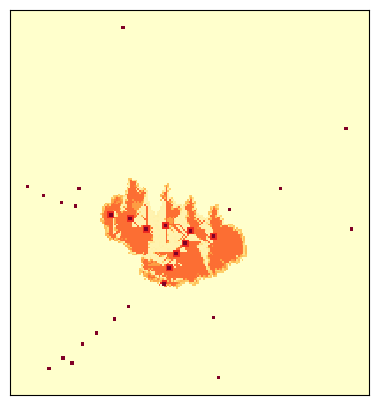

In [45]:
dish.animate(frames=50, interval=100, filename="output/50steps.gif")
plt.show()

Saving figure to file output/slime_graph_50steps.png


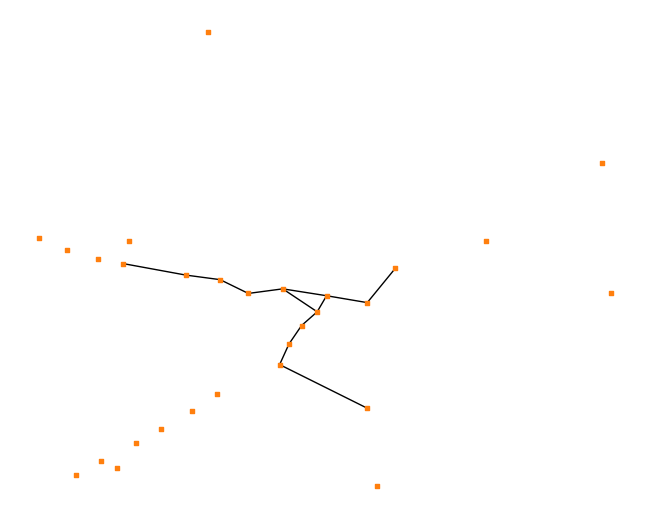

In [46]:
# Tạo một hình vẽ với kích thước 6.3x5 inch
fig = plt.figure(figsize=(6.3, 5))

# Vẽ đồ thị thức ăn từ food_graph, với các vị trí của các thức ăn từ food_positions
nx.draw(
    dish.food_graph,  # Đồ thị thức ăn
    dish.food_positions,  # Vị trí các thức ăn trên lưới
    node_color='C1',  # Màu của các nút (thức ăn)
    node_shape='s',  # Hình dạng của các nút (hình vuông)
    node_size=12,  # Kích thước các nút
    with_labels=False  # Không hiển thị nhãn cho các nút
)

# Lưu hình ảnh vào thư mục output dưới tên 'slime_graph_50steps.png'
savefig('output/slime_graph_50steps.png')


### Animate 50 + 100 steps

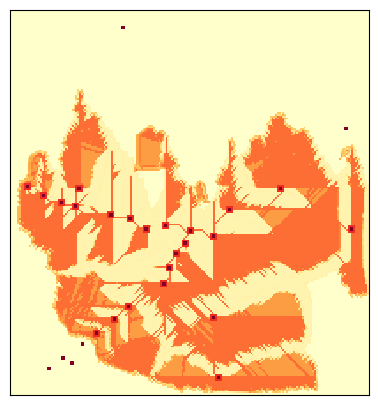

In [47]:
dish.animate(frames=100, interval=100, filename="output/150steps.gif")
plt.show()

Saving figure to file output/slime_graph_150steps.png


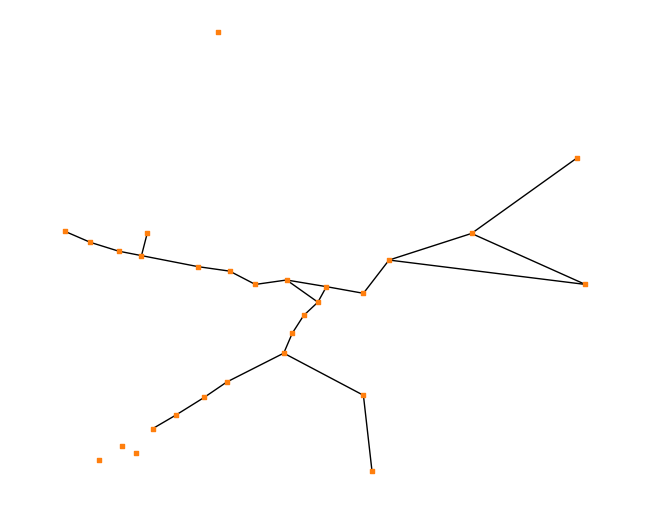

In [48]:
fig = plt.figure(figsize=(6.3, 5))
nx.draw(dish.food_graph, dish.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
savefig('output/slime_graph_150steps.png')

### Animate 50 + 100 + 100 steps

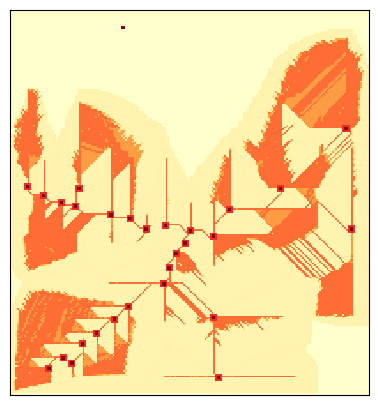

In [49]:
dish.animate(frames=100, interval=100, filename="output/250steps.gif")
plt.show()

Saving figure to file output/slime_graph_250steps.png


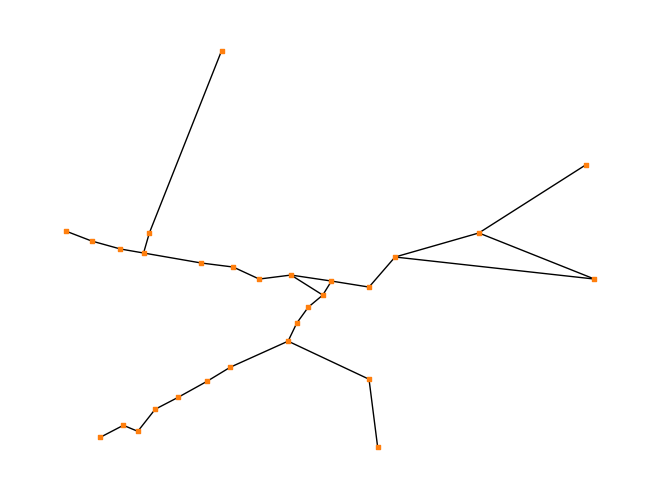

In [50]:
nx.draw(dish.food_graph, dish.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
savefig('output/slime_graph_250steps.png')

## Graph Analysis

### Statistics

In [51]:
# In ra hệ số phân cụm của đồ thị
print('Clustering coefficient:')
# Tính và in ra hệ số phân cụm của đồ thị gốc
print('Original graph: ' + str(clustering_coefficient(G)))
# Tính và in ra hệ số phân cụm của đồ thị đã được kết nối bởi slime mould
print('Graph connected by slime mould: ' + str(clustering_coefficient(dish.get_food_graph())))
print()

# In ra chiều dài đường đi đặc trưng của đồ thị
print('Path length:')
# Tính và in ra chiều dài đường đi đặc trưng của đồ thị gốc
print('Original graph: ' + str(characteristic_path_length(G)))
# Tính và in ra chiều dài đường đi đặc trưng của đồ thị đã được kết nối bởi slime mould
print('Graph connected by slime mould: ' + str(characteristic_path_length(dish.get_food_graph())))
print()

# In ra số lượng các nút trong đồ thị
print('Number of Nodes: ' + str(len(G.nodes)))
# In ra số lượng các cạnh trong đồ thị gốc
print('Number of edges in the original graph: ' + str(len(G.edges)))
# In ra số lượng các cạnh trong đồ thị đã được kết nối bởi slime mould
print('Number of edges in the graph connected by slime mould: ' + str(len(dish.get_food_graph().edges)))


Clustering coefficient:
Original graph: 0.0
Graph connected by slime mould: 0.1111111111111111

Path length:
Original graph: 6.0092592592592595
Graph connected by slime mould: 6.955665024630542

Number of Nodes: 29
Number of edges in the orginal graph: 27
Number of edges in the graph connected by slime mould: 30


### PMF in linear scale

Saving figure to file output/pmf.png


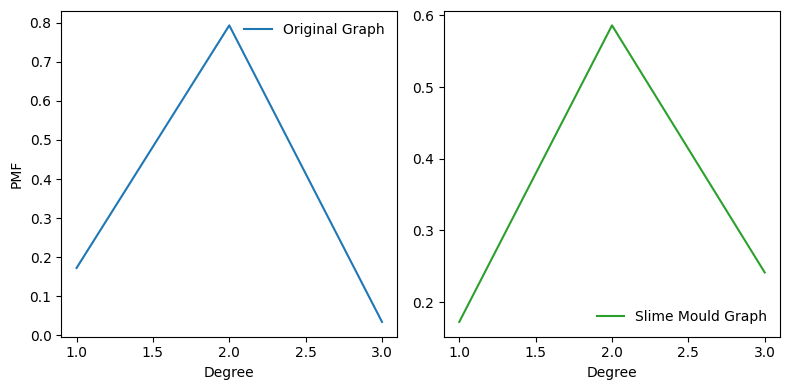

In [53]:
# Tạo phân phối xác suất cho đồ thị gốc
pmf_original = Pmf.from_seq(degrees(G))
# Tạo phân phối xác suất cho đồ thị đã được kết nối bởi slime mould
pmf_slime = Pmf.from_seq(degrees(dish.get_food_graph()))

# Tạo một biểu đồ với kích thước 8x4
plt.figure(figsize=(8, 4))

# Vẽ biểu đồ cho đồ thị gốc ở vị trí con trỏ (1,2,1) - Chia đôi đồ thị thành 2 phần ngang
plt.subplot(1, 2, 1)
# Vẽ phân phối xác suất cho đồ thị gốc với nhãn và màu sắc
pmf_original.plot(label='Original Graph', color='C0')
# Thêm nhãn cho trục x và y
decorate(xlabel='Degree', ylabel='PMF')

# Vẽ biểu đồ cho đồ thị slime mould ở vị trí con trỏ (1,2,2)
plt.subplot(1, 2, 2)
# Vẽ phân phối xác suất cho đồ thị slime mould với nhãn và màu sắc
pmf_slime.plot(label='Slime Mould Graph', color='C2')
# Thêm nhãn cho trục x
decorate(xlabel='Degree')

# Lưu ảnh đồ thị vào thư mục output với tên "pmf.png"
savefig('output/pmf.png')


## Agent Analysis

### Average pheromone of active agents

Saving figure to file output/avg_ph.png


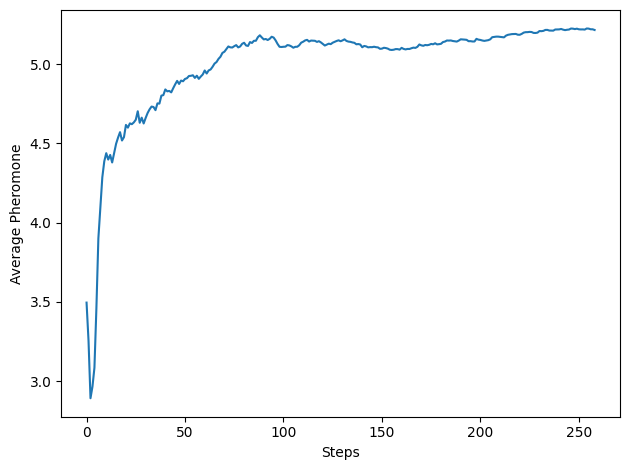

In [54]:
plt.plot(dish.mould.get_avg_ph())
decorate(xlabel='Steps', ylabel='Average Pheromone', loc='upper left')
savefig('output/avg_ph.png')

### Number of agents

Saving figure to file output/agent_num.png


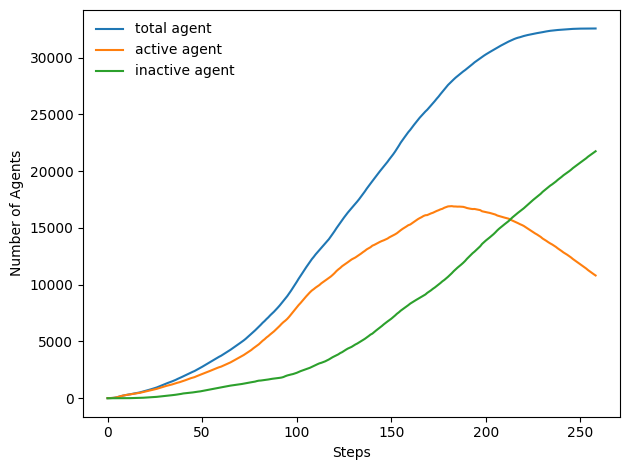

In [55]:
plt.plot(dish.mould.get_total_num(), label='total agent')
plt.plot(dish.mould.get_total_active_num(), label='active agent')
plt.plot(dish.mould.get_total_inactive_num(), label='inactive agent')
decorate(xlabel='Steps', ylabel='Number of Agents', loc='upper left')
savefig('output/agent_num.png')

### Slime mould coverage ratio

Saving figure to file output/cover_ratio.png


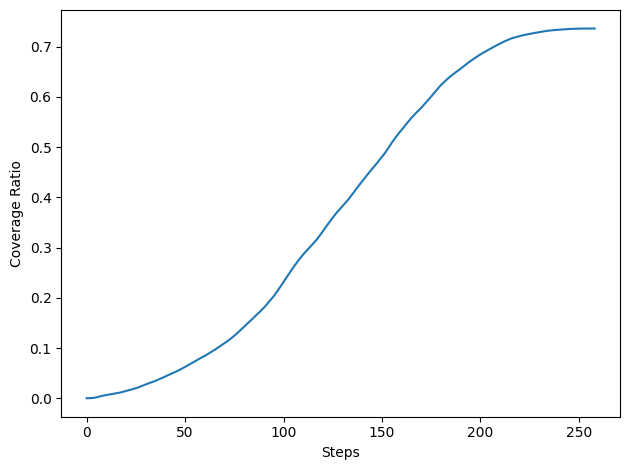

In [56]:
plt.plot(dish.mould.get_coverage_ratio())
decorate(xlabel='Steps', ylabel='Coverage Ratio', loc='upper left')
savefig('output/cover_ratio.png')

### Total number of connected food

Saving figure to file output/connected_food.png


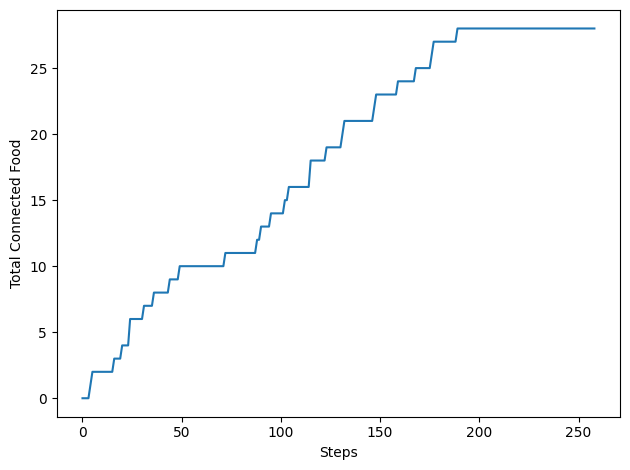

In [57]:
plt.plot(dish.mould.get_total_reached_foods())
decorate(xlabel='Steps', ylabel='Total Connected Food', loc='upper left')
savefig('output/connected_food.png')